In [1]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.3498],
        [-0.3974]], grad_fn=<AddmmBackward>)

## 参数访问

In [5]:
net[2].state_dict() # value是参数的data

OrderedDict([('weight',
              tensor([[-0.2736, -0.0112, -0.1577, -0.2415, -0.1812,  0.1543,  0.2608,  0.1211]])),
             ('bias', tensor([-0.2777]))])

In [20]:
net[2].state_dict()['weight'] # 通过key访问value（等效于net[2].weight.data）

tensor([[-0.2736, -0.0112, -0.1577, -0.2415, -0.1812,  0.1543,  0.2608,  0.1211]])

In [6]:
# 每个参数都是Parameter类的一个实例
print(type(net[2].bias))

print(net[2].bias)
print(net[2].bias.data) # 访问参数值

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.2777], requires_grad=True)
tensor([-0.2777])


In [7]:
# 参数是复合的对象，包含值、梯度和额外信息
net[2].weight.grad == None

True

## 遍历所有参数

In [12]:
# 遍历第一个全连接层的所有参数
print(*[(name, param.shape) for name, param in net[0].named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))


In [13]:
# 遍历网络中的所有参数
print(*[(name, param.shape) for name, param in net.named_parameters()])

('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


## 嵌套块的参数访问

In [21]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.0787],
        [0.0787]], grad_fn=<AddmmBackward>)

In [22]:
rgnet # 查看网络结构

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
# 通过索引访问到块中某层的参数
rgnet[0][1][0].bias

Parameter containing:
tensor([ 0.1982,  0.1769, -0.2003, -0.0119,  0.1922,  0.3351, -0.0793,  0.3987],
       requires_grad=True)

## 参数初始化

In [27]:
# PyTorch的nn.init模块提供了多种预置初始化方法
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01) # 从单独的正态分布中提取的随机数 （'方法名 + _'表示此方法会修改传入的对象）
        nn.init.zeros_(m.bias)

# 将网络中各个module都传入init_normal方法中
net.apply(init_normal)
# 参数访问
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0104, -0.0074,  0.0117,  0.0030]), tensor(0.))

In [28]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [29]:
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)
        
# 可以对不同模块使用不同的参数初始化方法
net[0].apply(init_xavier)
net[2].apply(init_42)
net[0].weight.data[0], net[2].weight.data

(tensor([-0.1880, -0.6493,  0.2308,  0.5194]),
 tensor([[42., 42., 42., 42., 42., 42., 42., 42.]]))

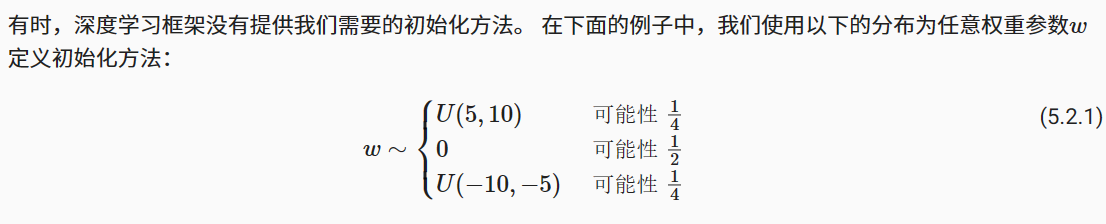

In [32]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape) for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5 # 将(-5,5)之间的值清零

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 5.5917,  7.0247, -6.5405,  8.3597],
        [-0.0000,  0.0000, -5.0993, -0.0000]], grad_fn=<SliceBackward>)

In [33]:
# 直接修改指定参数的值
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  8.0247, -5.5405,  9.3597])

## 网络中共享参数原理：同一个对象

In [35]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100 # 修改参数

# 它们实际上是同一个对象，不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])
print(net[2] == net[4]) # 共享参数本质就是同一个nn.Linear对象，自然参数一样

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])
True


 这里有一个问题：当参数绑定时，梯度会发生什么情况？ 答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层 （即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。